# Classify Digits with the MNIST Dataset

## Overview

## Models

In [1]:
import torch
import torch.nn as nn
import tqdm as tqdm # fancy progress bars
import matplotlib.pyplot as plt
import torchvision # for loading MNIST dataset and visualizing images


In [8]:
import onnx

def save_onnx(model, filename):
    base_path = "projects/blog/2-mnist/models/"
    dummy_input = torch.randn(1, 1, 28, 28)
    torch.onnx.export(model, dummy_input, base_path + filename, verbose=True, input_names=['images'], output_names=['classes'], export_params=True)

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)


In [5]:
def train(
    model,
    train_loader,
    test_loader,
    num_epochs=10,
    lr=0.1,
):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Statistics dictionary
    stats = {"train_losses": [0], "test_losses": [0], "global_step": 0}

    # Training loop
    with tqdm.trange(
        num_epochs, desc="Training", unit="epoch"
    ) as epochs:  # Adjust the number of epochs
        for epoch in epochs:
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                stats["train_losses"].append(loss.item())
                stats["global_step"] += 1

                epochs.set_postfix_str(f"train loss: {stats['train_losses'][-1]:.6f}, test loss: {stats['test_losses'][-1]:.6f}")

            model.eval()
            test_loss = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)

                    loss = criterion(outputs, labels)

                    test_loss += loss.item()

            stats["test_losses"].append(test_loss / len(test_loader))

    return stats

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def plot_stats(stats):
    # Plot train and test losses
    plt.figure(figsize=(20, 4))
    plt.plot(stats["train_losses"], label="Train Loss")
    plt.plot(
        range(
            len(train_loader),
            len(stats["train_losses"]) + len(train_loader),
            len(train_loader),
        ),
        stats["test_losses"],
        label="Test Loss",
        c="r",
    )
    plt.title("Train and Test Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()


### Feed Forward Neural Network

#### Baseline Linear Classifier

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")


Using device: cpu


Training: 100%|██████████| 10/10 [01:08<00:00,  6.86s/epoch, train loss: 0.497007, test loss: 0.298439]


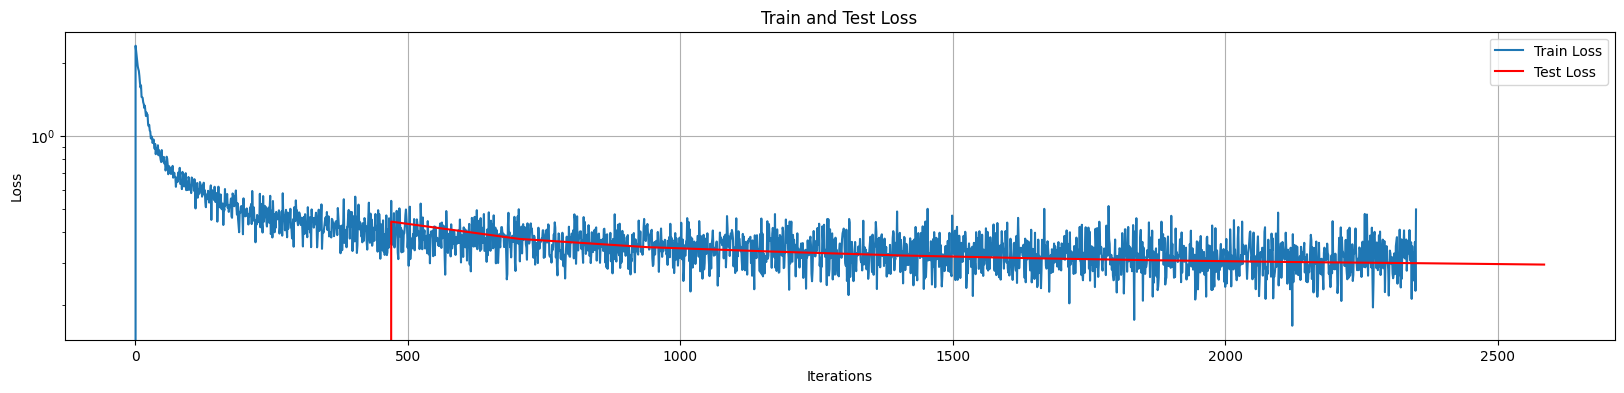

Accuracy: 0.9178
Model parameters: 7,850
Model size: 31,400 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %1.weight : Float(10, 784, strides=[784, 1], requires_grad=1, device=cpu),
      %1.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Flatten_output_0 : Float(1, 784, strides=[784, 1], requires_grad=0, device=cpu) = onnx::Flatten[axis=1, onnx_name="/0/Flatten"](%images), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.flatten.Flatten::0 # /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/flatten.py:49:0
  %classes : Float(1, 10, strides=[10, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/1/Gemm"](%/0/Flatten_output_0, %1.weight, %1.bias), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.linear.Linear::1 # /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/

In [9]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Flatten(), nn.Linear(28 * 28, 10)  # MNIST images are 28x28 and have 10 classes
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "baseline-linear-classifer.onnx")

#### One-Hidden-Layer Fully Connected Multilayer NN

Training: 100%|██████████| 10/10 [01:10<00:00,  7.00s/epoch, train loss: 0.294828, test loss: 0.221797]


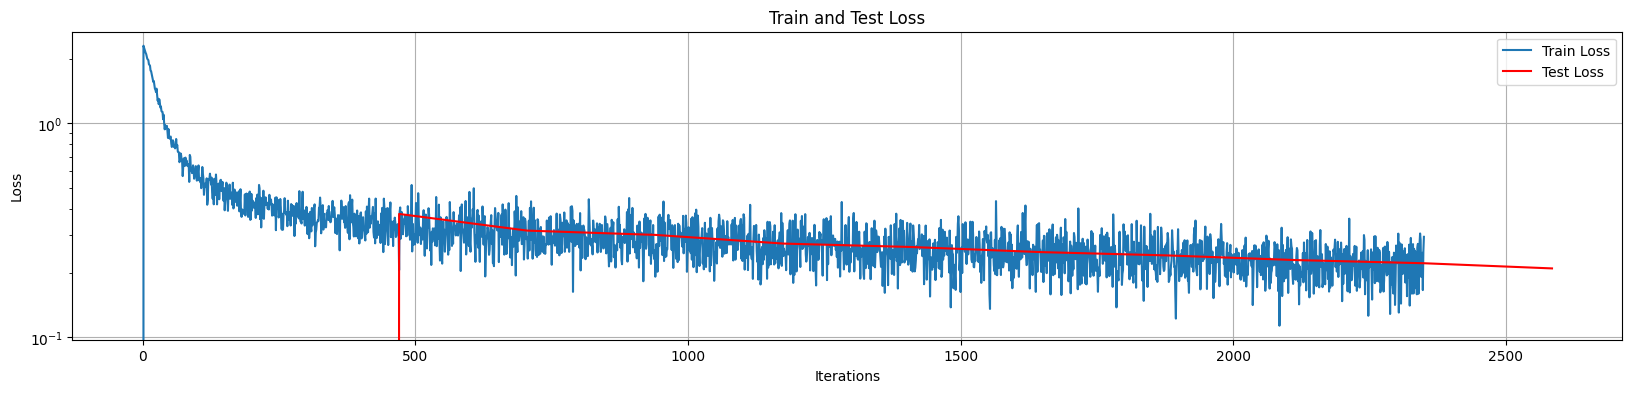

Accuracy: 0.9382
Model parameters: 203,530
Model size: 814,120 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %1.weight : Float(256, 784, strides=[784, 1], requires_grad=1, device=cpu),
      %1.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %3.weight : Float(10, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %3.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Flatten_output_0 : Float(1, 784, strides=[784, 1], requires_grad=0, device=cpu) = onnx::Flatten[axis=1, onnx_name="/0/Flatten"](%images), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.flatten.Flatten::0 # /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/flatten.py:49:0
  %/1/Gemm_output_0 : Float(1, 256, strides=[256, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/1/Gemm"](%/0/Flatten_output_0, %1.weight, %1.bias), s

In [10]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.Tanh(),
    nn.Linear(256, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "one-hidden-layer.onnx")

#### Two-Hidden-Layer Fully Connected Multilayer NN

Training: 100%|██████████| 10/10 [01:12<00:00,  7.29s/epoch, train loss: 0.089705, test loss: 0.178539]


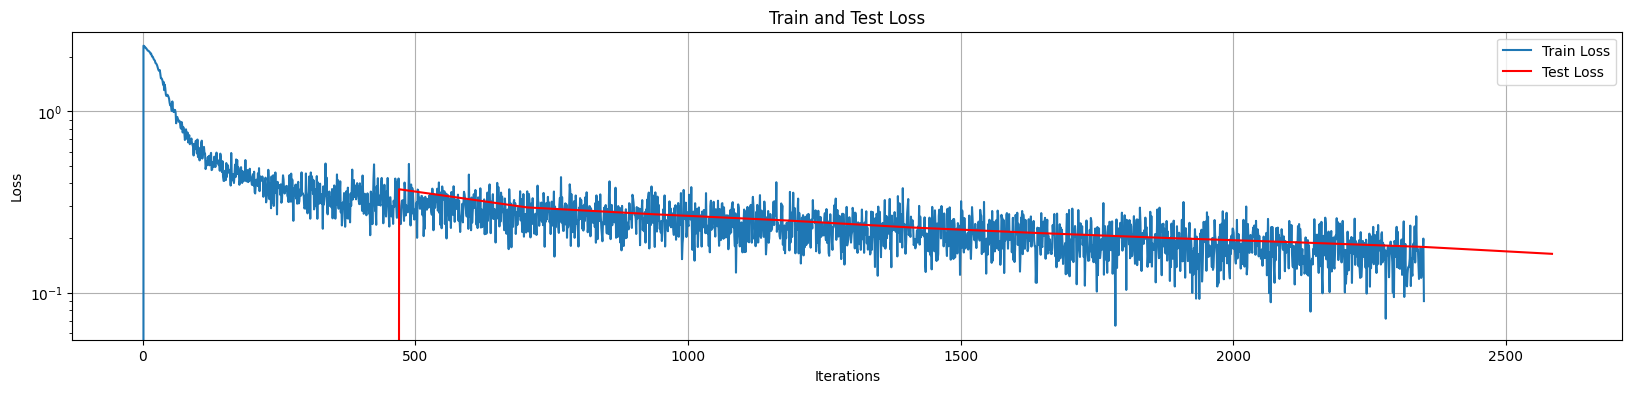

Accuracy: 0.9501
Model parameters: 235,146
Model size: 940,584 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %1.weight : Float(256, 784, strides=[784, 1], requires_grad=1, device=cpu),
      %1.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %3.weight : Float(128, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %3.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %5.weight : Float(10, 128, strides=[128, 1], requires_grad=1, device=cpu),
      %5.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Flatten_output_0 : Float(1, 784, strides=[784, 1], requires_grad=0, device=cpu) = onnx::Flatten[axis=1, onnx_name="/0/Flatten"](%images), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.flatten.Flatten::0 # /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/flatten.py:49:0
  %/1/Gemm_output_0 : Float(1, 256, st

In [11]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "two-hidden-layer.onnx")

### Convolutional Neural Network

#### LeNet-1

Training: 100%|██████████| 10/10 [01:58<00:00, 11.80s/epoch, train loss: 0.166938, test loss: 0.138672]


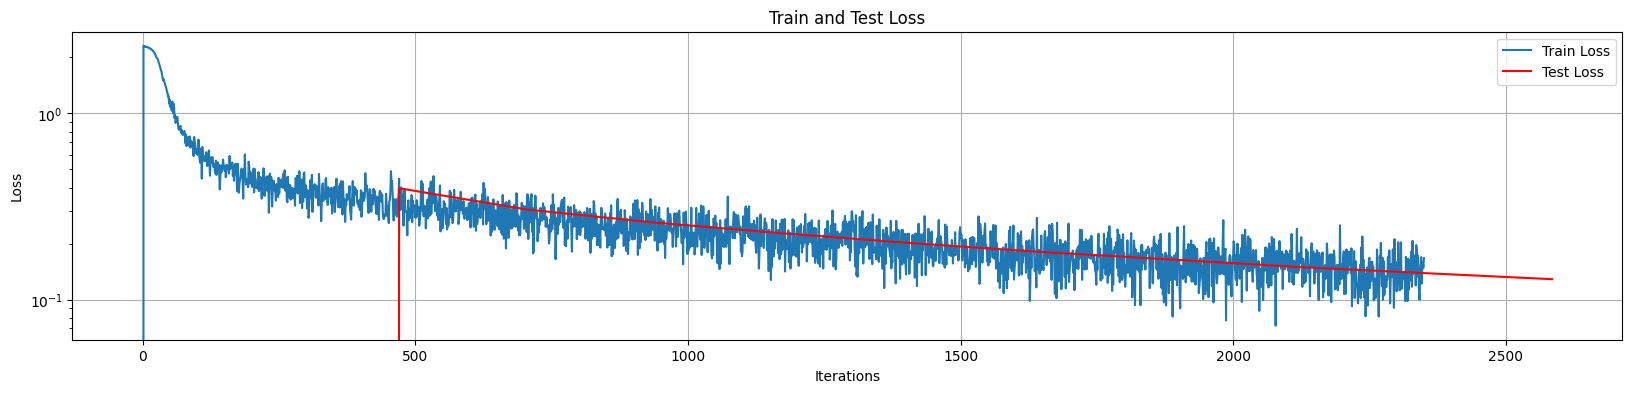

Accuracy: 0.9609
Model parameters: 3,246
Model size: 12,984 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %0.weight : Float(4, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %0.bias : Float(4, strides=[1], requires_grad=1, device=cpu),
      %3.weight : Float(12, 4, 5, 5, strides=[100, 25, 5, 1], requires_grad=1, device=cpu),
      %3.bias : Float(12, strides=[1], requires_grad=1, device=cpu),
      %7.weight : Float(10, 192, strides=[192, 1], requires_grad=1, device=cpu),
      %7.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Conv_output_0 : Float(1, 4, 24, 24, strides=[2304, 576, 24, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[1, 1], onnx_name="/0/Conv"](%images, %0.weight, %0.bias), scope: torch.nn.modules.container.Sequential::/torch.nn.modules.conv.Conv2d::0 # /home/zeus/miniconda3/envs/c

In [12]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(4, 12, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(192, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "lenet-1.onnx")

#### LeNet-4

Training: 100%|██████████| 10/10 [02:21<00:00, 14.19s/epoch, train loss: 0.126471, test loss: 0.088152]


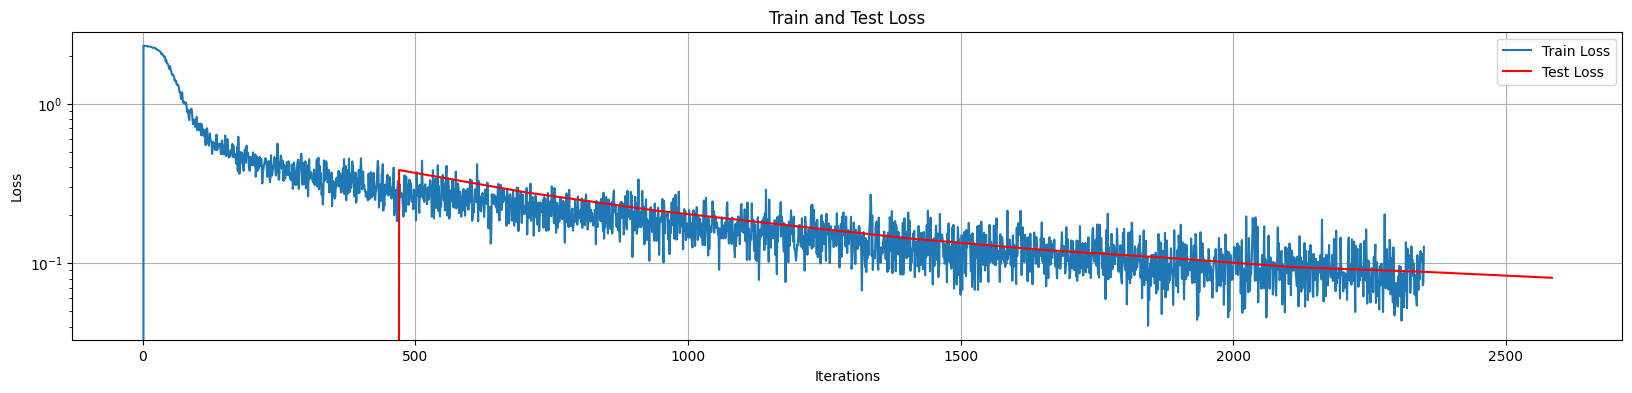

Accuracy: 0.9736
Model parameters: 33,770
Model size: 135,080 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %0.weight : Float(4, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %0.bias : Float(4, strides=[1], requires_grad=1, device=cpu),
      %3.weight : Float(16, 4, 5, 5, strides=[100, 25, 5, 1], requires_grad=1, device=cpu),
      %3.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %7.weight : Float(120, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %7.bias : Float(120, strides=[1], requires_grad=1, device=cpu),
      %9.weight : Float(10, 120, strides=[120, 1], requires_grad=1, device=cpu),
      %9.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Conv_output_0 : Float(1, 4, 24, 24, strides=[2304, 576, 24, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[1, 1], onnx_n

In [13]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(4, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 120),
    nn.Tanh(),
    nn.Linear(120, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "lenet-4.onnx")

#### LeNet-5

Training: 100%|██████████| 10/10 [02:25<00:00, 14.59s/epoch, train loss: 0.027139, test loss: 0.078916]


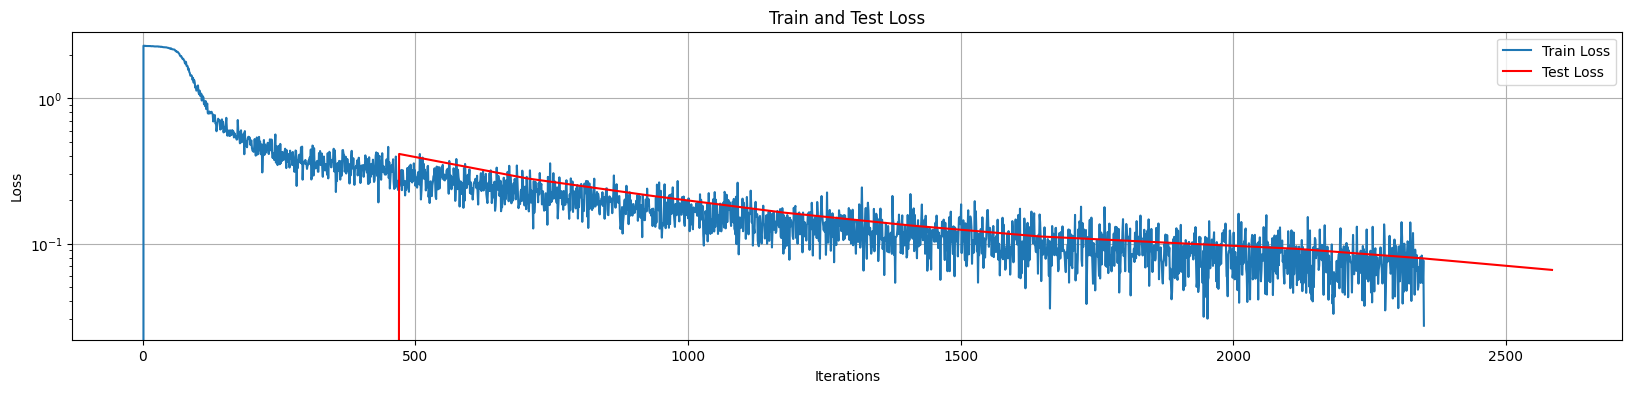

Accuracy: 0.9789
Model parameters: 44,426
Model size: 177,704 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %0.weight : Float(6, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %0.bias : Float(6, strides=[1], requires_grad=1, device=cpu),
      %3.weight : Float(16, 6, 5, 5, strides=[150, 25, 5, 1], requires_grad=1, device=cpu),
      %3.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %7.weight : Float(120, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %7.bias : Float(120, strides=[1], requires_grad=1, device=cpu),
      %9.weight : Float(84, 120, strides=[120, 1], requires_grad=1, device=cpu),
      %9.bias : Float(84, strides=[1], requires_grad=1, device=cpu),
      %11.weight : Float(10, 84, strides=[84, 1], requires_grad=1, device=cpu),
      %11.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Conv_output_0 : Float(1, 6, 24, 24, strides=[

In [14]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "lenet-5.onnx")

##### Optimized Training

In [ ]:
def train(
    model,
    train_loader,
    test_loader,
    num_epochs=10,
    lr=0.1,
    momentum=0.9, # Add 0.9 momentum
):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum) # Add momentum
    
    # Statistics dictionary
    stats = {"train_losses": [], "test_losses": [], "global_step": 0}

    # Training loop
    with tqdm.trange(
        num_epochs, desc="epochs", unit="epoch"
    ) as epochs:  # Adjust the number of epochs
        for epoch in epochs:
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                stats["train_losses"].append(loss.item())
                stats["global_step"] += 1

                epochs.set_postfix_str(f"loss: {loss.item():.4f}")

            model.eval()
            test_loss = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)

                    loss = criterion(outputs, labels)

                    test_loss += loss.item()

            stats["test_losses"].append(test_loss / len(test_loader))

    return stats


Training: 100%|██████████| 10/10 [02:35<00:00, 15.54s/epoch, train loss: 0.027139, test loss: 0.078916]


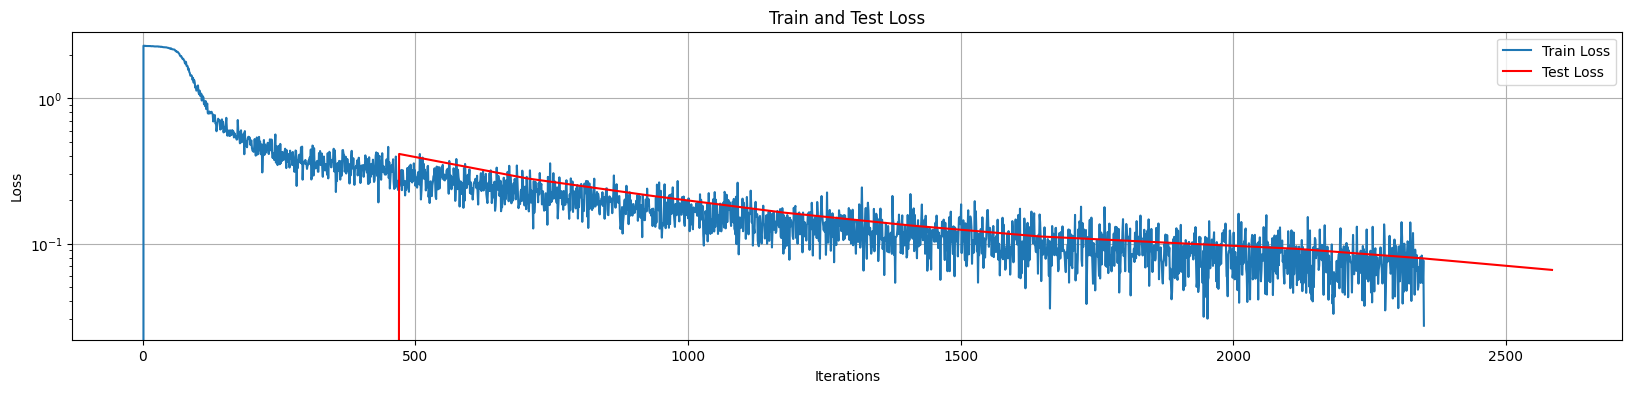

Accuracy: 0.9789
Model parameters: 44,426
Model size: 177,704 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %0.weight : Float(6, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %0.bias : Float(6, strides=[1], requires_grad=1, device=cpu),
      %3.weight : Float(16, 6, 5, 5, strides=[150, 25, 5, 1], requires_grad=1, device=cpu),
      %3.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %7.weight : Float(120, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %7.bias : Float(120, strides=[1], requires_grad=1, device=cpu),
      %9.weight : Float(84, 120, strides=[120, 1], requires_grad=1, device=cpu),
      %9.bias : Float(84, strides=[1], requires_grad=1, device=cpu),
      %11.weight : Float(10, 84, strides=[84, 1], requires_grad=1, device=cpu),
      %11.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Conv_output_0 : Float(1, 6, 24, 24, strides=[

In [15]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "lenet-5-momentum.onnx")

##### Smaller Batch Size

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False) # Doesnt matter if batch size is large

Training: 100%|██████████| 10/10 [02:47<00:00, 16.72s/epoch, train loss: 0.027139, test loss: 0.078916]


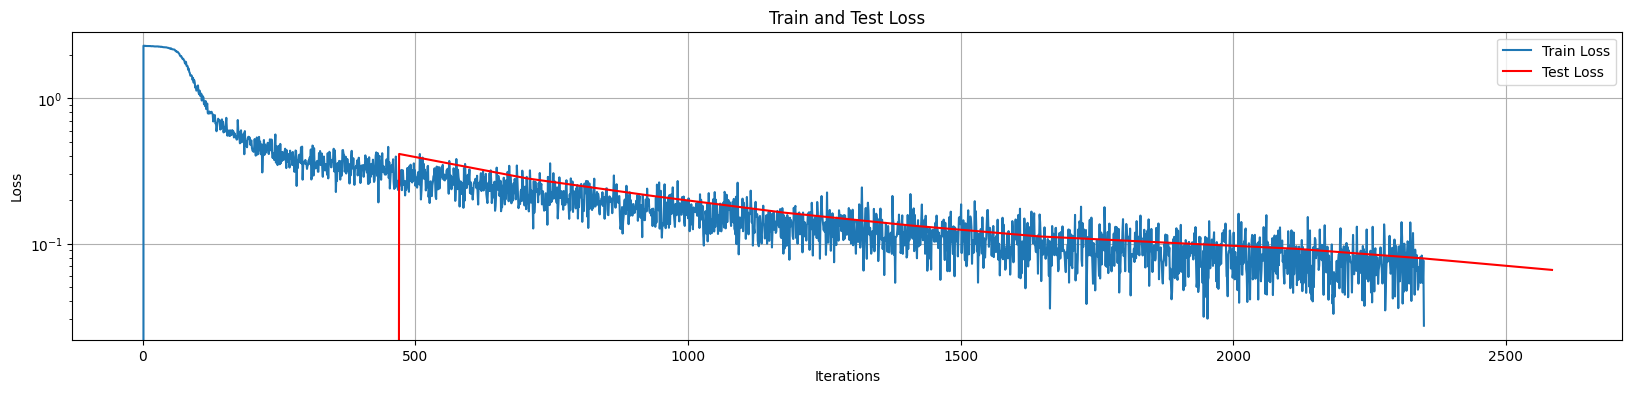

Accuracy: 0.9789
Model parameters: 44,426
Model size: 177,704 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %0.weight : Float(6, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %0.bias : Float(6, strides=[1], requires_grad=1, device=cpu),
      %3.weight : Float(16, 6, 5, 5, strides=[150, 25, 5, 1], requires_grad=1, device=cpu),
      %3.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %7.weight : Float(120, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %7.bias : Float(120, strides=[1], requires_grad=1, device=cpu),
      %9.weight : Float(84, 120, strides=[120, 1], requires_grad=1, device=cpu),
      %9.bias : Float(84, strides=[1], requires_grad=1, device=cpu),
      %11.weight : Float(10, 84, strides=[84, 1], requires_grad=1, device=cpu),
      %11.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Conv_output_0 : Float(1, 6, 24, 24, strides=[

In [16]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(256, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "lenet-5-momentum-small-batch.onnx")

##### 2020's

Training: 100%|██████████| 10/10 [12:48<00:00, 76.84s/epoch, train loss: 0.044444, test loss: 0.077015]


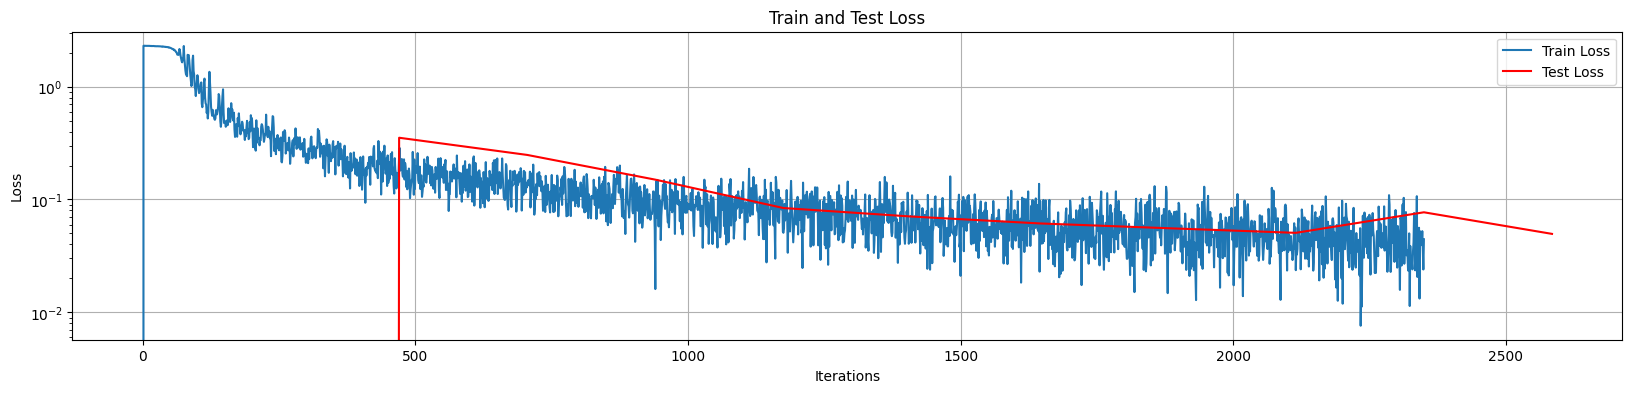

Accuracy: 0.9835
Model parameters: 763,186
Model size: 3,052,744 bytes
Exported graph: graph(%images : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %0.weight : Float(64, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %3.weight : Float(128, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cpu),
      %3.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %7.weight : Float(256, 2048, strides=[2048, 1], requires_grad=1, device=cpu),
      %7.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %9.weight : Float(120, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %9.bias : Float(120, strides=[1], requires_grad=1, device=cpu),
      %11.weight : Float(10, 120, strides=[120, 1], requires_grad=1, device=cpu),
      %11.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/0/Conv_output_0 : Float(1, 64, 2

In [17]:
torch.manual_seed(0) # for reproducibility if you care about that

# Define the model
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(2),
    nn.Conv2d(64, 128, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Linear(128*4*4, 256),
    nn.ReLU(),
    nn.Linear(256, 120),
    nn.ReLU(),
    nn.Linear(120, 10),
).to(device)

stats = train(model, train_loader, test_loader)

plot_stats(stats)

print(f"Accuracy: {test(model, test_loader):.4f}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in model.parameters()):,} bytes")

save_onnx(model, "lenet-5-momentum-small-batch-relu-wide.onnx")